Load the needed libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')     # This prevents displays of warnings which can be a distruction to viewing outputs
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
from gensim import corpora
from gensim.models import ldamodel, CoherenceModel
from gensim.parsing.preprocessing import remove_stopwords
from gensim import utils
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import pandas as pd
import statistics
import string
import os
import re
import json
from textblob import TextBlob
import emoji
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

## Exploratory Data Analysis

The data was downloaded from twitter and saved as a json file

Creating a function to read and load the data form the json file

In [2]:
def read_json(json_file: str)->list:
    """
    json file reader to open and read json files into a list
    Args:
    -----
    json_file: str - path of a json file
    
    Returns
    -------
    length of the json file and a list of json
    """
    
    tweets_data = []
    for tweets in open(json_file,'r'):
        tweets_data.append(json.loads(tweets))
    
    
    return len(tweets_data), tweets_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading and loading the data with <b>read_json()</b> function

In [3]:
data_source = "./data/covid19.json"

# reading the data and putting the total number of entries (tweet_len) and data (tweet_list) in variables
tweet_len, tweet_list = read_json(data_source)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creating a class and methods to extract the tweets and create a pandas dataframe from them

In [4]:
class TweetDfExtractor:
    """
    this function will parse tweets json into a pandas dataframe
    
    Return
    ------
    dataframe
    """
    def __init__(self, tweets_list):
        
        self.tweets_list = tweets_list

    # an example function
    def find_statuses_count(self)->list:
        statuses_count = [i['user']['statuses_count'] for i in self.tweets_list]
        return statuses_count 
        
    def find_full_text(self)->list:
        text = []
        for i in self.tweets_list:
            if 'retweeted_status' in i.keys():
                if 'extended_tweet' in i['retweeted_status'].keys():
                    text.append(i['retweeted_status']['extended_tweet']['full_text'])
                else:
                    text.append(i['text'])
            else:
                if 'extended_tweet' in i.keys():
                    text.append(i['extended_tweet']['full_text'])
                else:
                    text.append(i['text'])
        return text
       
    
    def find_sentiments(self, text)->list:
        polarity = [TextBlob(i).polarity for i in text]
        self.subjectivity = [TextBlob(i).subjectivity for i in text]
        return polarity, self.subjectivity

    def find_created_time(self)->list:
        created_at = [i['created_at'] for i in self.tweets_list]
        return created_at

    def find_source(self)->list:
        source = [i['source'] for i in self.tweets_list]
        return source

    def find_screen_name(self)->list:
        screen_name =[i['user']['screen_name'] for i in self.tweets_list]
        return screen_name

    def find_followers_count(self)->list:
        followers_count = [i['user']['followers_count'] for i in self.tweets_list]
        return followers_count

    def find_friends_count(self)->list:
        friends_count = [i['user']['friends_count'] for i in self.tweets_list]
        return friends_count

    def is_sensitive(self)->list:
        is_sensitive = []
        for i in self.tweets_list:
            try:
                is_sensitive.append(i['possibly_sensitive'])
            except KeyError:
                is_sensitive.append(None)
        return is_sensitive

    def find_favourite_count(self)->list:
        favorite_count = []
        for i in self.tweets_list:
            if 'retweeted_status' in i.keys():
                favorite_count.append(i['retweeted_status']['favorite_count'])
            else:
                favorite_count.append(i['favorite_count'])
        return favorite_count
    
    def find_retweet_count(self)->list:
        retweet_count = []
        for i in self.tweets_list:
            if 'retweeted_status' in i.keys():
                retweet_count.append(i['retweeted_status']['retweet_count'])
            else:
                retweet_count.append(i['retweet_count'])
        return retweet_count

    def find_hashtags(self)->list:
        hashtags = [i['entities']['hashtags'] for i in self.tweets_list]
        return hashtags

    def find_mentions(self)->list:
        mentions = [i['entities']['user_mentions'] for i in self.tweets_list]
        return mentions

    def find_location(self)->list:
        try:
            location = [i['user']['location'] for i in self.tweets_list]
        except TypeError:
            location = ''
        
        return location

    def find_lang(self)->list:
        lang = [i['lang'] for i in self.tweets_list]
        return lang
    
            
    def get_tweet_df(self, save=False)->pd.DataFrame:
        
        columns = ['created_at', 'source', 'original_text','polarity','subjectivity', 'lang', 'favorite_count', 'retweet_count', 
            'original_author', 'followers_count','friends_count','possibly_sensitive', 'hashtags', 'user_mentions', 'place']
        
        created_at = self.find_created_time()
        source = self.find_source()
        text = self.find_full_text()
        polarity, subjectivity = self.find_sentiments(text)
        lang = self.find_lang()
        fav_count = self.find_favourite_count()
        retweet_count = self.find_retweet_count()
        screen_name = self.find_screen_name()
        follower_count = self.find_followers_count()
        friends_count = self.find_friends_count()
        sensitivity = self.is_sensitive()
        hashtags = self.find_hashtags()
        mentions = self.find_mentions()
        location = self.find_location()
        data = zip(created_at, source, text, polarity, subjectivity, lang, fav_count, retweet_count, screen_name, follower_count, friends_count, sensitivity, hashtags, mentions, location)
        df = pd.DataFrame(data=data, columns=columns)

        if save:
            df.to_csv('processed_tweet_data.csv', index=False)
            print('File Successfully Saved.!!!')
        
        return df


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using the <b>TweetDfExtractor</b> class to create a pandas dataframe

In [5]:
tweet = TweetDfExtractor(tweet_list)    # creates an instance of TweetDfExtractor
tweet_df = tweet.get_tweet_df()         # creates pandas dataframe using get_tweet_df method of TweetDfExtractor

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creating a class and methods to prepare data for visualization

In [6]:
class TweetDfDataPreparation:
    """
    this function will prepare tweets data form tweet dataframe for modelling and visualization
    
    Return
    ------
    dataframe
    """
    def __init__(self, tweets_df):
        
        self.tweets_df = tweets_df
        
    def print_df_info(self) -> None:
        """
        this function will print the info of the tweets datafame

        Return
        ------
        None
        """
        #save the number of columns and names
        col_info = 'The number of colum(s): {}.\nThe column(s) is/are : {} and {}'.format(len(self.tweets_df.columns),','.join(self.tweets_df.columns[:-2]), self.tweets_df.columns[-1])  
        
        #save the number of rows
        num_rows = "\nThe total number of rows: {}".format(len(self.tweets_df))
        
        #save the number of duplicate tweets
        num_dup_tweets = '\nThe number of duplicate tweets: {}'.format(len(self.tweets_df)-len(self.tweets_df.original_text.unique()))
        
        na_cols = self.tweets_df.columns[self.tweets_df.isnull().any()]
        
        #save the number of missing values
        num_na_cols = "\nThe number of columns having missing value(s): {}".format(len(na_cols))
        
        #save the columns with missing value and the num of values missing
        na_cols_num_na = ''
        
        for col in na_cols:
            na_cols_num_na += "\nThe number of rows with missing value(s) in [{}]: {}".format(col, self.tweets_df[col].isnull().sum())
        
        # save the total number of missing values
        tot_na = "\nThe total number of missing value(s): {}".format(self.tweets_df.isnull().sum().sum())
        
        print(col_info, num_rows, num_dup_tweets, num_na_cols, na_cols_num_na, tot_na)
        
        
    def slice_dataframe(self, columns=['created_at', 'original_text', 'polarity', 'subjectivity'],output=True)->pd.DataFrame:
        """
        this function will slice of the tweets datafame. it takes a list of columns to slice and a bolean, output. 
        If its True it returns cleaned tweet

        Return
        ------
        dataframe if output=True, None if output=False
        """
        #sliced_tweet_df = self.tweets_df[columns]
        self.sliced_tweet_df = self.tweets_df[columns]
        if output:
            return self.sliced_tweet_df
        return None
    
    def drop_tweet_dup(self, column_name='original_text',output=True)->pd.DataFrame:
        """
        this function will drop duplicates tweets in slicedtweet datafame. 
        it takes the name of column with the tweets in string format as an argument and 
        a bolean, output. If its True it returns cleaned tweet

        Return
        ------
        dataframe if output=True, None if output=False
        """
        sliced_tweet_df = self.sliced_tweet_df
        sliced_tweet_df.drop_duplicates([column_name], inplace=True)
        self.sliced_tweet_df = sliced_tweet_df
        
        if output:
            return self.sliced_tweet_df
        return None
        
        
    def clean_tweet(self, column_name='original_text', cleaned_tweet_column_name='cleaned_tweet', output=True)->pd.DataFrame:
        """
        this function will clean tweets in slicedtweet datafame. 
        it takes the name of column with the tweets and that of the new column for the cleaned tweet 
        both in string format as an argument and a bolean, output. If its True it returns cleaned tweet

        Return
        ------
        dataframe if output=True, None if output=False
        """
        unwanted = ["'\n',''"]
        take_out = ''
        for char in unwanted:
            take_out = string.punctuation + char 
        
        def remove_punct_and_clean(tweet)->str:
            # removes emojis
            tweet = emoji.get_emoji_regexp().sub(r'', tweet)
            # removes punctuations and newline characters
            tweet  = "".join([char for char in tweet if char not in take_out])
            # removes digits
            tweet = re.sub('[0-9]+', '', tweet)
            # converts to lowercase
            tweet = tweet.lower()
            return tweet
        
        sliced_tweet_df = self.sliced_tweet_df
        sliced_tweet_df[cleaned_tweet_column_name] = sliced_tweet_df[column_name].apply(remove_punct_and_clean)
        self.sliced_tweet_df = sliced_tweet_df
        if output:
            return self.sliced_tweet_df
        return None
        
    def convert_to_datetime(self, column_name='created_at', output=True)->pd.DataFrame:
        """
        this function will convert a parsed column in sliced tweet datafame to datetime. 
        it takes the name of column with the dates in string format as an argument and a bolean, output. 
        If its True it returns dataframe with the converted dates

        Return
        ------
        dataframe if output=True, None if output=False
        """
        sliced_tweet_df = self.sliced_tweet_df
        sliced_tweet_df[column_name] = pd.to_datetime(sliced_tweet_df[column_name])
        self.sliced_tweet_df = sliced_tweet_df

        if output:
            return self.sliced_tweet_df
        return None
    
    def classify_polarity(self, column_name='polarity', cassified_column_name='classified_polarity', output=True)->pd.DataFrame:
        """
        this function will classify a pared column in sliced tweet datafame with polarity. 
        it takes the name of column with the polarity and that of the new column for the classified polarityscores 
        both in string format as an argument and a bolean, output. If its True it returns a dataframe with the classified column added

        Return
        ------
        dataframe if output=True, None if output=False
        """
        
        def classify(value)->str:
            """
            this function will classify numbers. it takes the number be calssified as an argument
            
            Return
            --------
            string
            """
            if value > 0.5:
                return 'very positive'
            elif value > 0:
                return 'positive'
            elif value < -0.5:
                return 'very negative'
            elif value < 0:
                return 'negative'
            else:
                return 'neutral'
            
        sliced_tweet_df = self.sliced_tweet_df
        sliced_tweet_df[cassified_column_name] = sliced_tweet_df[column_name].apply(classify)
        self.sliced_tweet_df = sliced_tweet_df
        if output:
            return self.sliced_tweet_df
        return None
        
        
    def classify_subjectivity(self, column_name='subjectivity', cassified_column_name='classified_subjectivity', output=True)->pd.DataFrame:
        """
        this function will classify a parsed column in sliced tweet datafame with subjectivity. 
        it takes the name of column with the polarity and that of the new column for the classified subjectivity scores 
        both in string format as an argument and a bolean, output. If its True it returns a dataframe with the classified column added

        Return
        ------
        dataframe if output=True, None if output=False
        """

        def classify(value)->str:
            """
            this function will classify numbers. it takes the number be calssified as an argument

            Return
            --------
            string
            """
            if value > 0.7:
                return 'very subjective'
            elif value > 0.2:
                return 'subjective'
            else:
                return 'factual'

        sliced_tweet_df = self.sliced_tweet_df
        sliced_tweet_df[cassified_column_name] = sliced_tweet_df[column_name].apply(classify)
        self.sliced_tweet_df = sliced_tweet_df
        if output:
            return self.sliced_tweet_df
        return None
    
    def create_data_for_model(self, column_list=['cleaned_tweet','polarity'], polarity_column='polarity', output=True)->pd.DataFrame:
        
        def classify(value)->int:
            """
            this function will classify numbers. it takes the number be calssified as an argument

            Return
            --------
            string
            """
            if value > 0:
                return 1
            else:
                return 0
        x = self.sliced_tweet_df[column_list]
        x = x[x[polarity_column] != 0].reset_index(drop=True)
        x['label'] = x[polarity_column].apply(classify)
        columns = list(x.columns)
        columns.remove(polarity_column)
        data_for_model = x[columns]
        return data_for_model

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creating functions to implement and automate data processing

In [7]:
def get_cleaned_tweet_and_data_for_model(uncleaned_tweet_df)->pd.DataFrame:
    prep = TweetDfDataPreparation(uncleaned_tweet_df)
    prep.slice_dataframe(output=False)
    prep.drop_tweet_dup(output=False)
    prep.convert_to_datetime(output=False)
    prep.classify_polarity(output=False)
    prep.classify_subjectivity(output=False)
    cleaned = prep.clean_tweet()
    data_for_model = prep.create_data_for_model()
    return cleaned, data_for_model

def get_df_info(df)->None:
    prep = TweetDfDataPreparation(df)
    prep.print_df_info()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Implementing data cleaning

In [8]:
get_df_info(tweet_df)
cleaned_tweet, data_for_model = get_cleaned_tweet_and_data_for_model(tweet_df)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The number of colum(s): 15.
The column(s) is/are : created_at,source,original_text,polarity,subjectivity,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags and place 
The total number of rows: 6532 
The number of duplicate tweets: 4237 
The number of columns having missing value(s): 2 
The number of rows with missing value(s) in [possibly_sensitive]: 5014
The number of rows with missing value(s) in [place]: 2444 
The total number of missing value(s): 7458


In [ ]:
data_for_model

In [9]:
class TweetDFTopicModeling:
    """
    this function will create topic modeling model parsed data for modeling
    
    Return
    ------
    dict
    """
    
    def __init__(self, df):
        self.data = df
        
    def prepare_data(self)->None:
        """
        this function will prepare data for creating topic modeling model 
        Return
        ------
        None
        """
        
        data = self.data
        #Converting tweets to list of words For feature engineering
        sentence_list = [remove_stopwords(tweet) for tweet in data['cleaned_tweet']]
        word_list = [sent.split() for sent in sentence_list]

        #Create dictionary which contains Id and word 
        word_to_id = corpora.Dictionary(word_list)
        corpus_1= [word_to_id.doc2bow(tweet) for tweet in word_list]
        data = {'word_list':word_list, 'word_to_id':word_to_id, 'corpus':corpus_1 }
        
        self.data = data
        
    def creat_topic_model (self)->dict:
        """
        this function will create topic modeling model 

        Return
        ------
        dict
        """
        data = self.data
        corpus = data['corpus']
        word_to_id = data['word_to_id']
        lda_model = ldamodel.LdaModel(corpus,
                                           id2word=word_to_id,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=50,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=True)
        self.model = lda_model
        return lda_model
    
    def viz_lda_topics(self):
        
        data = self.data
        lda_model = self.model
        corpus = data['corpus']
        word_to_id = data['word_to_id']
        # Visualize the topics
        pyLDAvis.enable_notebook()

        LDAvis_prepared = gensimvis.prepare(lda_model, corpus, word_to_id)
        return LDAvis_prepared

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
b = TweetDFTopicModeling(data_for_model)
b.prepare_data()
lda = b.creat_topic_model()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

In [ ]:
u

In [ ]:
viz = b.viz_lda_topics()

In [ ]:
viz

In [ ]:
lda.show_topics(formatted=False)

Creating a class and methods to create and save vizsualization

In [126]:
class TweetDfVisualization:
    
    def __init__(self, processedDf):
        self.df = processedDf
        
    
    def create_wordcloud(self):
        # Displays a figure of the most used words
        plt.figure(figsize=(20, 10))
        plt.imshow(WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(' '.join(self.df.cleaned_tweet.values)))
        plt.axis('off')
        plt.title('Most Frequent Words In Tweets',fontsize=16)
        plt.savefig('wordcloud.png')
        plt.show()

    def create_viz(self):
        red='#FF5C5C'
        dark_green = '#00A300'
        yellow = '#FFC55C'
        blue = '#7EC8E3'
        green = '#00D100'
        plt.rcParams['axes.labelsize'] = 20
        #plt.rcParams['axes.titlesize'] = 16
        
        category_color_dict = {'very negative':red, 'negative':yellow, 'neutral':blue, 'positive':green, 'very positive':dark_green}
        fig, axes = plt.subplots(2,2, figsize=(20, 20))
        plt.rcParams.update({'axes.titlesize': 'Large'})
        
        axes[0,0].tick_params(axis='x', labelsize=16)
        axes[0,0].tick_params(axis='y', labelsize=16)
        
        axes[0,1].tick_params(axis='x', labelsize=16)
        axes[0,1].tick_params(axis='y', labelsize=16)
        axes[0,1].set_title('POLARITY COUNT', fontsize=22)
        
        axes[1,0].tick_params(axis='x', labelsize=16)
        axes[1,0].tick_params(axis='y', labelsize=16)
        axes[1,0].set_title('POLARITY WITH SUBJECTIVITY', fontsize=22)
        
        axes[1,1].tick_params(axis='x', labelsize=16)
        axes[1,1].tick_params(axis='y', labelsize=16)
        axes[1,1].set_title('SUBJECTIVITY COUNT', fontsize=22)
        
        temp_select_df = self.df['classified_polarity'].value_counts(sort=False)
        explode = (0.4, 0.4, 0.4, 0.4, 0.4)
        colors= [category_color_dict[i] for i in temp_select_df.index]

        temp_select_df.plot.pie(ax=axes[0,0] ,ylabel='', autopct='%1.1f%%',
                 shadow=True, startangle=90, explode = explode, colors=colors, fontsize=16)
        

        sns.countplot(ax=axes[1,0], data=self.df, x='classified_polarity', hue='classified_subjectivity', palette="ch:1")
        sns.set_context('paper')
        sns.set_style('dark')
        axes[1,0].set(xlabel='Polarity', ylabel='Count')
        axes[1,0].legend(title='Subjectivity', loc='best', fontsize=14, title_fontsize=16)
        plt.subplots_adjust(top = 0.96, bottom=0.05, hspace=0.3, wspace=0.4)
        

        colors= [category_color_dict[i] for i in temp_select_df.index]
        temp_select_df = self.df['classified_polarity'].value_counts(sort=False)
        temp_select_df.plot.bar(ax=axes[0,1] ,xlabel='Polarity', ylabel='Count', color=colors)

        sns.countplot(ax=axes[1,1], data=self.df, x='classified_subjectivity', palette="ch:1")
        axes[1,1].set(xlabel='Count', ylabel='Polarity')

        #plt.show()

        plt.savefig('viz.png')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Implementing <b>TweetDfVisualization</b> to create visualization

In [127]:
viz = TweetDfVisualization(cleaned_tweet)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
viz.create_wordcloud()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


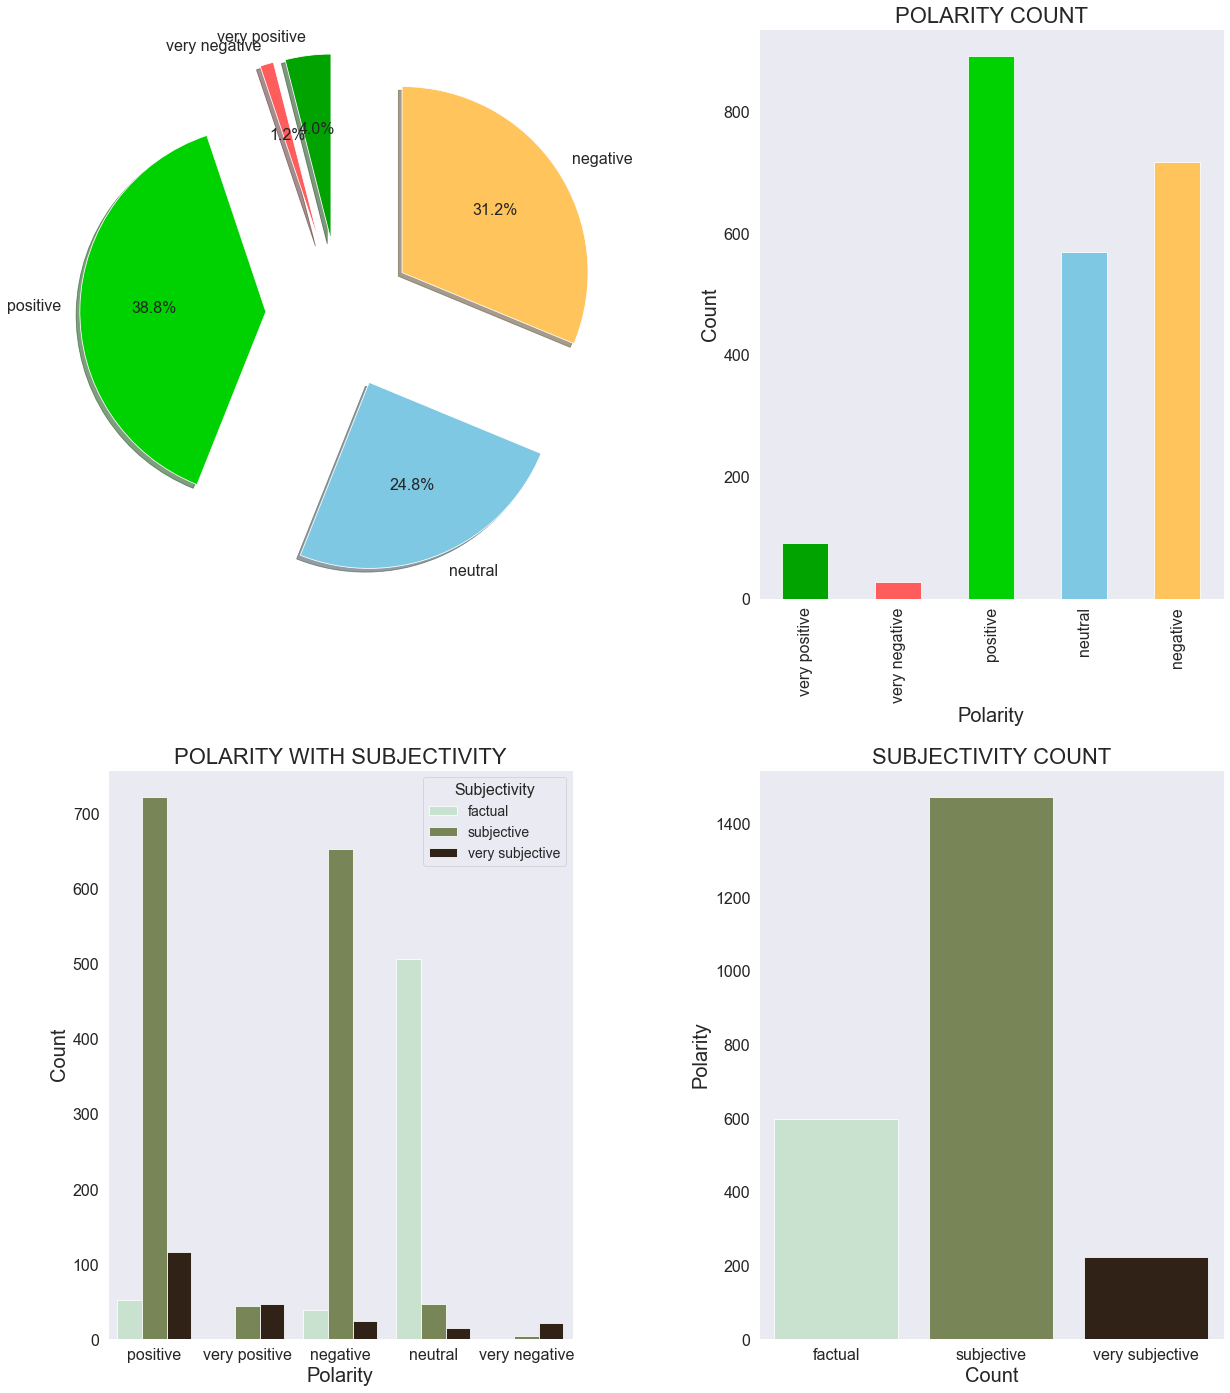

In [128]:
viz.create_viz()

In [ ]:
class TweetDFTrain:
    """
    this function will prepare parsed data for modeling
    
    Return
    ------
    dataframe
    """
    
    def __init__(self, processedDf, max_n_grams):
        self.processedDf = processedDf
        self.max_n_grams = max_n_grams
        
    def vectorize_data(self)->None:
        """
        this function will vectorize data for training the model

        Return
        ------
        None
        """
        max_n_grams = self.max_n_grams
        data = {str(i+1)+'_gram':'' for i in range(max_n_grams)}
        
        for i in range(max_n_grams):
            vectorizer = CountVectorizer(ngram_range=(1,i+1))
            vectorizer.fit(self.processedDf['cleaned_tweet'].values)
            data[str(i+1)+'_gram'] = vectorizer.transform(self.processedDf['cleaned_tweet'].values)
            
        self.data = data
        
    def tf_id_data(self)->None:
        """
        this function will compute the tf-id of data for training the model

        Return
        ------
        None
        """
        data_1 = self.data
        data = {}
        vectorized_data_tf_id = {}
        for key in data_1.keys():
            transformer = TfidfTransformer()
            transformer.fit(data_1[key])
            data[key+'_tf_id'] = transformer.transform(data_1[key])
        data_1.update(data)  
        self.data = data_1
        
    def train_model(self)->dict:
        """
        this function will train and select the optimized model for each of the parsed proceeded variant of data

        Return
        ------
        dictionary
        """
        data = self.data
        y = self.processedDf['label']
        models = {}
        for key in data.keys():
            X=data[key]
            X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.75, stratify=y)
            
            model = SGDClassifier()
            distributions = dict(
                loss=['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
                learning_rate=['optimal', 'invscaling', 'adaptive'],
                eta0=uniform(loc=1e-7, scale=1e-2),
                penalty=['l1', 'l2', 'elasticnet'],
                alpha=uniform(loc=1e-6, scale=1e-4)
            )
            random_search_cv = RandomizedSearchCV(
                estimator=model,
                param_distributions=distributions,
                cv=5,
                n_iter=50
            )
            random_search_cv.fit(X_train, y_train)
            model = random_search_cv.best_estimator_
            model.fit(X_train, y_train)
            model_data = {'X_train':X_train, 'X_valid':X_valid, 'y_train':y_train, 'y_valid':y_valid, 'model':model}
            models[key+'_model'] = model_data
        return models   

In [ ]:
def get_trained_models(df:pd.DataFrame,max_n_grams:int)->dict:
    """
    this function will vectorize, compute tf-id and train the models. It takes the processed data as a first argument 
    and maximum n-grams as a secon argument

    Return
    ------
    dictionary
    """
    models = TweetDFTrain(df,max_n_grams)
    models.vectorize_data()
    models.tf_id_data()
    trained_models = models.train_model()
    return trained_models

In [ ]:
class TweetDFModelEvaluate:
    """
    this function will evaluate and select the best performing model and optimize its performance
    
    Return
    ------
    dict
    """
    
    def __init__ (self, models):
        self.models = models
        
    def evaluate_model(self):
        """
        this function will evaluate the trained models

        Return
        ------
        None
        """
        models = self.models
        for key in models.keys():
            X_train = models[key]['X_train']
            X_valid = models[key]['X_valid']
            y_train = models[key]['y_train']
            y_valid = models[key]['y_valid']
            model = models[key]['model']
            train_score = model.score(X_train, y_train)
            valid_score = model.score(X_valid, y_valid)
            models[key]['train_score'] = train_score
            models[key]['valid_score'] = valid_score
            
        self.models =  models
        
    def select_model(self):
        """
        this function will select the best performing trained model

        Return
        ------
        dict
        """
        models = self.models
        max_valid_score = 0
        selected_model = ''
        num_of_models = len(models.keys())
        print('The number of trained models are {}'.format(num_of_models))
        for key in models.keys():
            train_score = models[key]['train_score']
            valid_score = models[key]['valid_score']
            print('\nmodel name : {}\nTraining Score : {}\nValidation Score : {}'.format(key, train_score, valid_score))

            if models[key]['valid_score'] > max_valid_score:
                max_valid_score = models[key]['valid_score']
                selected_model = {'name': key, 'train_score':train_score, 'valid_score':valid_score, 'model': models[key]['model']}

        print('\nThe best performing and selected model is {}'.format(selected_model['name']))
        self.models = selected_model
        return selected_model

In [ ]:
models = get_trained_models(data_for_model, 3)

In [ ]:
a = TweetDFModelEvaluate(models)
a.evaluate_model()
a.select_model()

In [ ]:
models['1_gram_model'].keys()

In [ ]:
SGDClassifier.score?

In [ ]:
SGDClassifier().validate